In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from __future__ import division
from glob import glob
import os
import time
import cPickle as pickle

import scipy.linalg
import scipy.stats

import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

import emcee
import numdifftools

import kepler
import threebody

## Computing pulse numbers for some six-vectors

In [78]:
#infilename = "0337_6vec_table_GBT_Lband_fold_150131.fits"
#infilename = "0337_6vec_table_141009.fits"
infilename = "0337_6vec_table_150131.fits"
outfilename = infilename.replace(".fits","_pulses.fits")


In [79]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)

In [80]:
V = astropy.table.Table.read(infilename)

In [81]:
btoas_t = astropy.time.Time(np.asarray(V['btoas'][:,0]),
                            np.asarray(V['btoas'][:,1]),
                            format='jd',
                            scale='tdb').tcb # our F0 value is TCB
btoas = (btoas_t.jd1-2400000.5-F.base_mjd).astype(np.float128) + btoas_t.jd2.astype(np.float128)

In [82]:
# FIXME: jumps
o = threebody.compute_orbit(F.best_parameters, btoas)

In [83]:
t_psr_s = o['t_psr']*86400
p = F.best_parameters
tzrmjd_base = p['tzrmjd_base']
tzrmjd_s = (p['tzrmjd']+(tzrmjd_base-F.base_mjd))*86400
phase = p['f0']*t_psr_s+p['f1']*t_psr_s**2/2.
phase -= p['f0']*tzrmjd_s+p['f1']*tzrmjd_s**2/2.

7 questionable entries


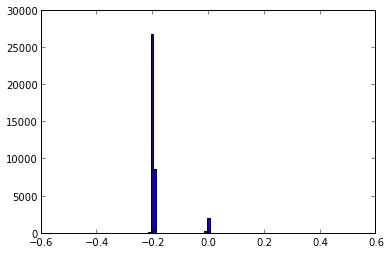

In [84]:
plt.hist(phase-np.round(phase),bins=100)
print np.sum(np.abs(phase-np.round(phase)>0.3)), "questionable entries"

In [85]:
pulses = np.round(phase).astype(np.int64)

In [86]:
if 'pulse' in V.colnames:
    print "Pulse number column already present"
    print np.sum(pulses!=V['pulse']), "entries discrepant"
else:
    V.add_column(astropy.table.Column(data=pulses, name='pulse'))


In [87]:
V.write(outfilename)

## Building a good forecaster

In [3]:
fpickle = "fitter_params.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)

In [4]:
F.chi2(F.best_parameters), len(F.mjds)

(34392.586632432234214, 34570)

In [5]:
lp = F.compute_linear_parts()

In [6]:
lp

{'f0': 365.95336311711874977,
 'f1': -2.3547358099795740666e-15,
 'tzrmjd': 180.00018851636843117,
 'tzrmjd_base': 55920}

In [7]:
F.best_parameters

{'acosi_i': 1.4917920737881377967,
 'acosi_o': 91.515517821405981132,
 'asini_i': 1.2175268187146886046,
 'asini_o': 74.672709901274213484,
 'd_DECJ': 3.8297379260835209625e-07,
 'd_RAJ': -9.1473641598984196357e-08,
 'dbeta': 3.137215781113322372e-05,
 'delta': -2.4326288381809617149e-10,
 'delta_lan': -5.4096316391090949558e-05,
 'dgamma': -2.5854449182822343408e-07,
 'eps1_i': 0.00068724728071223587401,
 'eps1_o': 0.035186247652040840626,
 'eps2_i': -9.1179836780626676656e-05,
 'eps2_o': -0.003462135260726911092,
 'f0': 365.95336311711874974,
 'f1': -2.3547358099625887817e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055121663140921818248,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053763724410558742536,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969394546642386,
 'pb_o': 327.2575252205244358,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13746673219074406775,
 

In [8]:
d2 = d.copy()
d2['tzrmjd_middle'] = False
p2 = F.best_parameters.copy()
for k in lp:
    p2[k] = lp[k]

In [9]:
F2 = threebody.Fitter(**d2)

In [10]:
try:
    old = F2.chi2(F2.best_parameters)
    print "old:", old
except KeyError:
    old = np.inf
new = F2.chi2(p2)
print "new:", new
if new<old:
    bpd = threebody.load_best_parameter_database()
    bpd[frozenset(F2.args.iteritems())] = p2
    threebody.save_best_parameter_database(bpd)

old: 34392.5866324
new: 34392.5867662


In [11]:
with open("forecaster_params.pickle", "wb") as f:
    pickle.dump(d2, f)